In [1]:
import numpy as np
import pandas as pd
from scipy.special import exp10
from matplotlib import pylab as plt

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error

from SeqMM.pyBayOpt.skGPEI import GPEISklearn

# Example 1: SVM for Classification


Search completed in 93.75 seconds.
The best score is: 0.98070.
The best configurations are:
C                   : 4.52452
gamma               : 0.30881


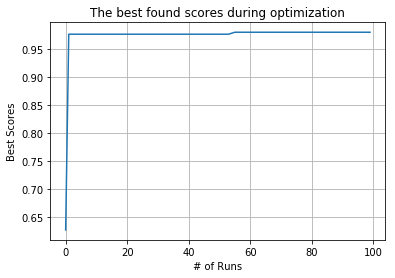

In [2]:
from sklearn import svm

sx = MinMaxScaler()
dt = datasets.load_breast_cancer()
x = sx.fit_transform(dt.data)
y = dt.target

ParaSpace = {'C':     {'Type': 'continuous', 'Range': [-6, 16], 'Wrapper': np.exp2}, 
             'gamma': {'Type': 'continuous', 'Range': [-16, 6], 'Wrapper': np.exp2}}

estimator = svm.SVC()
score_metric = make_scorer(accuracy_score, True)
cv = KFold(n_splits=5, random_state=0, shuffle=True)

clf = GPEISklearn(estimator, cv, ParaSpace, max_runs = 100, time_out = 10, refit = True, verbose = True)
clf.fit(x, y)
clf.plot_scores()

A contour plot based on a thorough grid search

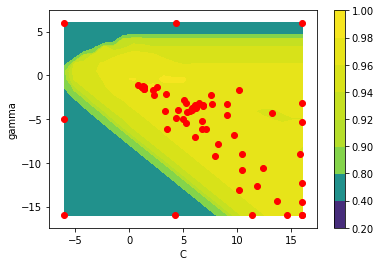

In [3]:
grid_num = 25
xlist = np.linspace(-6, 16, grid_num)
ylist = np.linspace(-16, 6, grid_num)
X, Y = np.meshgrid(xlist, ylist)
Z = np.zeros((grid_num,grid_num))
for i, C in enumerate(xlist):
    for j, gamma in enumerate(ylist):
        estimator = svm.SVC(C=2**C,gamma = 2**gamma)
        out = cross_val_score(estimator, x, y, cv = cv, scoring = score_metric)
        Z[j,i] = np.mean(out)
        
levels = [0.2, 0.4, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0]
cp = plt.contourf(X, Y, Z, levels)
plt.colorbar(cp)
plt.xlabel('C')
plt.ylabel('gamma')
plt.scatter(np.log2(clf.logs.loc[:,['C']]), 
            np.log2(clf.logs.loc[:,['gamma']]), color = "red")
plt.show()

# Example 2: Xgboost for Regression

In [4]:
import xgboost as xgb

dt = datasets.load_diabetes()
sx = MinMaxScaler()
x = sx.fit_transform(dt.data)
y = dt.target

ParaSpace = {'booster':          {'Type': 'categorical', 'Mapping': ['gbtree', 'gblinear']},
             'max_depth':        {'Type': 'integer',     'Mapping': np.linspace(2,10,9)}, 
             'n_estimators':     {'Type': 'integer',     'Mapping': np.linspace(100,500,401)},
             'min_child_weight': {'Type': 'integer',     'Mapping': np.linspace(1,100,100)},
             'subsample':        {'Type': 'continuous',  'Range': [0, 1],  'Wrapper': lambda x:x},
             'colsample_bytree': {'Type': 'continuous',  'Range': [0, 1],  'Wrapper': lambda x:x},
             'learning_rate':    {'Type': 'continuous',  'Range': [-5, 1], 'Wrapper': np.exp2},
             'gamma':            {'Type': 'continuous',  'Range': [-5, 1], 'Wrapper': np.exp2},
             'reg_lambda':       {'Type': 'continuous',  'Range': [-5, 1], 'Wrapper': np.exp2},
             'reg_alpha':         {'Type': 'continuous',  'Range': [-5, 1], 'Wrapper': np.exp2}}

estimator = xgb.XGBRegressor()
score_metric = make_scorer(mean_squared_error, False)
cv = KFold(n_splits=5, random_state=0, shuffle=True)

clf = GPEISklearn(estimator, cv, ParaSpace, max_runs = 100, scoring = score_metric, time_out = 20, refit = True, verbose = True)
clf.fit(x, y)
clf.logs


Search completed in 554.74 seconds.
The best score is: -3309.50713.
The best configurations are:
booster             : gblinear
max_depth           : 8
n_estimators        : 323
min_child_weight    : 54
subsample           : 0.67278
colsample_bytree    : 0.47006
learning_rate       : 0.49738
gamma               : 0.40842
reg_lambda          : 0.03125
reg_alpha           : 0.2475


,booster,max_depth,n_estimators,min_child_weight,subsample,colsample_bytree,learning_rate,gamma,reg_lambda,reg_alpha,score
0,gbtree,2,100,1,0.000000,0.000000,0.031250,0.031250,0.031250,0.031250,-28926.020991
1,gbtree,6,300,50,0.500000,0.500000,0.250000,0.250000,0.250000,0.250000,-3653.251244
2,gblinear,4,400,25,0.750000,0.250000,0.707107,0.088388,0.088388,0.707107,-3982.790834
3,gblinear,6,275,51,0.756836,0.674805,0.429074,1.359767,0.073029,0.241027,-3739.682410
4,gblinear,6,275,51,0.756836,0.674805,0.429074,1.359767,0.073029,0.241027,-3739.682410
5,gblinear,5,258,71,0.449219,0.371094,0.742423,0.718688,0.245971,0.536467,-4704.953745
6,gblinear,6,275,51,0.756836,0.674805,0.429074,1.359767,0.073029,0.241027,-3739.682410
7,gblinear,6,275,51,0.756836,0.674805,0.429074,1.359767,0.073029,0.241027,-3739.682410
8,gblinear,6,275,51,0.756836,0.674805,0.429074,1.359767,0.073029,0.241027,-3739.682410
9,gblinear,6,275,51,0.756836,0.674805,0.429074,1.359767,0.073029,0.241027,-3739.682410


 # Example 3: Kmeans for Unsupervised Clustering  

In [5]:
from sklearn.cluster import KMeans

sx = MinMaxScaler()
dt = datasets.load_iris()
x = sx.fit_transform(dt.data)
y = dt.target.reshape([-1,1])

ParaSpace = {'n_clusters':  {'Type': 'integer',    'Mapping': np.linspace(2,9,8)}, 
             'tol':         {'Type': 'continuous', 'Range': [-6, -3], 'Wrapper': exp10}}

estimator = KMeans()
cv = KFold(n_splits=5, random_state=0, shuffle=True)

clf = GPEISklearn(estimator, cv, ParaSpace, max_runs = 100, refit = True, verbose = True)
clf.fit(x, y)
clf.logs


Search completed in 82.02 seconds.
The best score is: -0.65715.
The best configurations are:
n_clusters          : 9
tol                 : 0.00011


,n_clusters,tol,score
0,2,0.000001,-2.489966
1,5,0.000032,-0.990443
2,8,0.000183,-0.768507
3,7,0.001000,-0.827184
4,8,0.000001,-0.789091
5,9,0.000013,-0.722542
6,9,0.001000,-0.721881
7,9,0.000001,-0.727910
8,9,0.000005,-0.707012
9,9,0.000005,-0.730145
